# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20230818_LCLS_optimize/"
print(sys.path)

['/home/physics3/rroussel/SLAC_Xopt/lcls/optimization', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../', '../']


## Set up image diagnostic

In [2]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols: ROI_XNP, array_n_rows: ROI_YNP,
  resolution: RESOLUTION, background_file: /home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230818_LCLS_optimize/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, testing: false}



In [3]:
#image_diagnostic.measure_background(file_location=run_dir)

In [4]:
image_diagnostic.background_file

'/home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy'

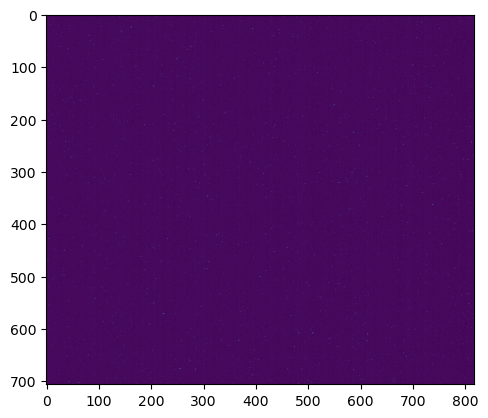

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

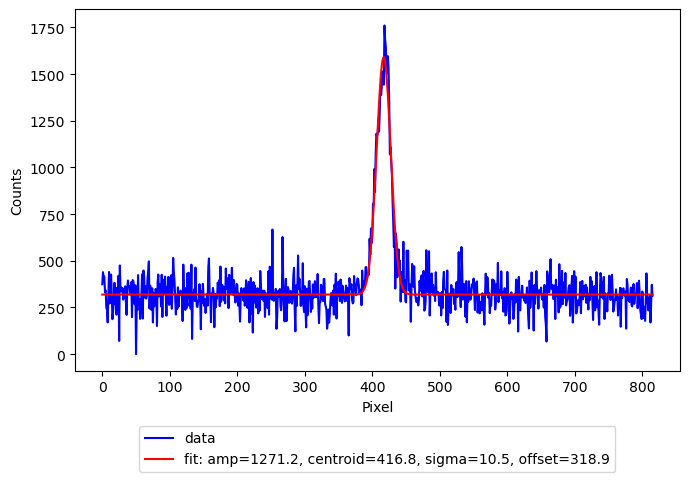

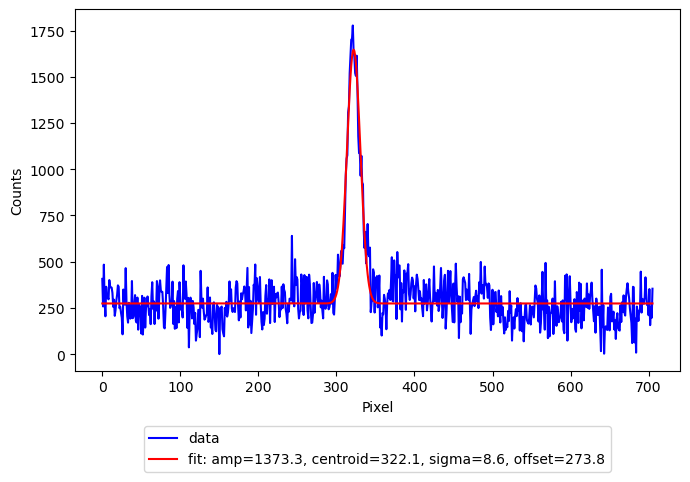

{'Cx': 416.80186345568256,
 'Cy': 322.10355872053094,
 'Sx': 127.28671563196569,
 'Sy': 104.35415867848306,
 'bb_penalty': -206.14443712253814,
 'total_intensity': 1043228.9999999995,
 'log10_total_intensity': 6.0183796512069785}

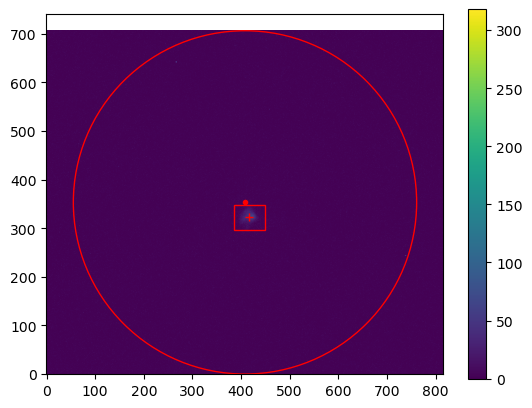

In [6]:
image_diagnostic.test_measurement()

In [7]:
import pandas as pd
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [8]:
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL",'QUAD:IN20:361:BCTRL','QUAD:IN20:371:BCTRL','QUAD:IN20:425:BCTRL','QUAD:IN20:441:BCTRL','QUAD:IN20:511:BCTRL','QUAD:IN20:525:BCTRL']
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        constraints = IMAGE_CONSTRAINTS,
        objectives = {"total_size": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.377, 0.498], 'QUAD:IN20:121:BCTRL': [-0.021, 0.021], 'QUAD:IN20:122:BCTRL': [-0.021, 0.021], 'QUAD:IN20:361:BCTRL': [-4.32, -1.08], 'QUAD:IN20:371:BCTRL': [1.09, 4.31], 'QUAD:IN20:425:BCTRL': [-7.56, -1.08], 'QUAD:IN20:441:BCTRL': [-1.08, 7.56], 'QUAD:IN20:511:BCTRL': [-1.08, 7.56], 'QUAD:IN20:525:BCTRL': [-7.56, -1.08]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={'total_size': 'MINIMIZE'} constants={} observables=[]


In [9]:
from epics import caput, caget_many
from time import sleep
import numpy as np
def eval_beamsize(inputs):
        # set PVs
        for k, v in inputs.items():
            print(f'CAPUT {k} {v}')
            caput(k, v)

        sleep(2.0)

        # get beam sizes from image diagnostic
        metadata = inputs | image_diangostic.dict()
        results = image_diagnostic.measure_beamsize(5, **metadata)
        results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
        results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

        # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
        results = results

        # add total beam size
        results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
        return results

In [10]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    turbo_controller="optimize"
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 2.0a1+63.g53057de
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: null, max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller:
    dim: 9
    batch_size: 1
    length: 0.25
    length_min: 0.0078125
    length_max: 2.0
    failure_counter: 0
    failure_tolerance: 5
    success_counter: 0
    success_tolerance: 5
    center_x: null
    scale_factor: 2.0
    tkwargs: {dtype: torch.float64}
    minimize: true
    best_value: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 200}
  max_travel_distances: null
  fixed_features: null
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: __main__.eval_beamsize
  max_workers: 1
  function_kwargs: {}
  vectorize

In [11]:
default = {'SOLN:IN20:121:BCTRL': 0.4726221999999998,
 'QUAD:IN20:121:BCTRL': -0.0048398437,
 'QUAD:IN20:122:BCTRL': 0.0018000000000000004,
 'QUAD:IN20:361:BCTRL': -3.16,
 'QUAD:IN20:371:BCTRL': 2.5352702,
 'QUAD:IN20:425:BCTRL': -1.5,
 'QUAD:IN20:441:BCTRL': -0.8118599,
 'QUAD:IN20:511:BCTRL': 3.6494056,
 'QUAD:IN20:525:BCTRL': -3.2522187}

In [12]:
import pandas as pd
X.evaluate_data(pd.DataFrame(default, index=[0]))

CAPUT SOLN:IN20:121:BCTRL 0.4726221999999998
CAPUT QUAD:IN20:121:BCTRL -0.0048398437
CAPUT QUAD:IN20:122:BCTRL 0.0018000000000000004
CAPUT QUAD:IN20:361:BCTRL -3.16
CAPUT QUAD:IN20:371:BCTRL 2.5352702
CAPUT QUAD:IN20:425:BCTRL -1.5
CAPUT QUAD:IN20:441:BCTRL -0.8118599
CAPUT QUAD:IN20:511:BCTRL 3.6494056
CAPUT QUAD:IN20:525:BCTRL -3.2522187


,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.044692,...,235.570489,-187.994917,1044008.8,6.018704,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073073,0.23557,246.643712,6.820862,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.044943,...,235.582322,-187.991587,1044008.8,6.018704,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073083,0.235582,246.658002,6.820862,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.812742,...,219.288474,-191.333508,1052554.0,6.022244,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.075339,0.219288,231.869487,6.820862,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.45711,...,234.118904,-184.085835,1043307.2,6.018412,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073255,0.234119,245.312049,6.820862,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,NaN,...,NaN,564.280084,1063872.2,6.026889,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,NaN,NaN,NaN,6.820862,False


In [13]:
X.data

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.044692,...,235.570489,-187.994917,1044008.8,6.018704,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073073,0.23557,246.643712,6.820862,False
2,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.044943,...,235.582322,-187.991587,1044008.8,6.018704,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073083,0.235582,246.658002,6.820862,False
3,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.812742,...,219.288474,-191.333508,1052554.0,6.022244,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.075339,0.219288,231.869487,6.820862,False
4,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.45711,...,234.118904,-184.085835,1043307.2,6.018412,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.073255,0.234119,245.312049,6.820862,False
5,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,NaN,...,NaN,564.280084,1063872.2,6.026889,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,NaN,NaN,NaN,6.820862,False


In [20]:
for i in range(10):
    print(i)
    X.step()

0
CAPUT QUAD:IN20:121:BCTRL -0.0017212284685570746
CAPUT QUAD:IN20:122:BCTRL 0.0038974865931872705
CAPUT QUAD:IN20:361:BCTRL -3.0757659947204217
CAPUT QUAD:IN20:371:BCTRL 2.389848432005462
CAPUT QUAD:IN20:425:BCTRL -2.169238165597264
CAPUT QUAD:IN20:441:BCTRL 0.11536207149796582
CAPUT QUAD:IN20:511:BCTRL 3.5590549247671404
CAPUT QUAD:IN20:525:BCTRL -3.806118993301958
CAPUT SOLN:IN20:121:BCTRL 0.4763398550330744
1
CAPUT QUAD:IN20:121:BCTRL -0.0017261713551309475
CAPUT QUAD:IN20:122:BCTRL 0.003885732901410315
CAPUT QUAD:IN20:361:BCTRL -3.0924811758346364
CAPUT QUAD:IN20:371:BCTRL 2.3837554669292076
CAPUT QUAD:IN20:425:BCTRL -2.1798364462688298
CAPUT QUAD:IN20:441:BCTRL 0.0775205230916478
CAPUT QUAD:IN20:511:BCTRL 3.555137247015165
CAPUT QUAD:IN20:525:BCTRL -3.810243358181641
CAPUT SOLN:IN20:121:BCTRL 0.47644702911003134
2
CAPUT QUAD:IN20:121:BCTRL -0.001666836487892608
CAPUT QUAD:IN20:122:BCTRL 0.003879622897535438
CAPUT QUAD:IN20:361:BCTRL -3.0950574359651704
CAPUT QUAD:IN20:371:BCTRL 2

<Axes: >

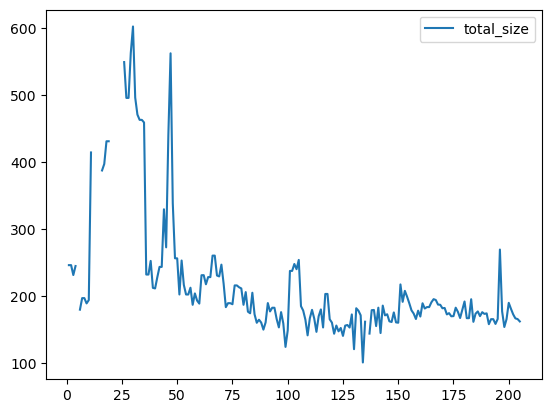

In [21]:
X.data.plot(y="total_size")

<Axes: >

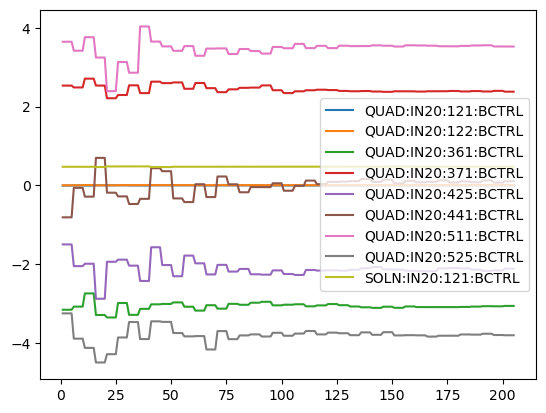

In [22]:
X.data.plot(y=X.vocs.variable_names)

In [27]:
X.data.head()["total_size"].mean()

242.62081217603858

In [28]:
X.data.tail()["total_size"].mean()

170.1646417339693

In [29]:
X.data["total_size"].min()

101.43224982729883

In [33]:
X.options.dump_file = "optimization_results.yml"
X.dump_state()

In [37]:
from scripts.utils.read_files import read_file
res = read_file(X.data.iloc[10]["save_filename"])

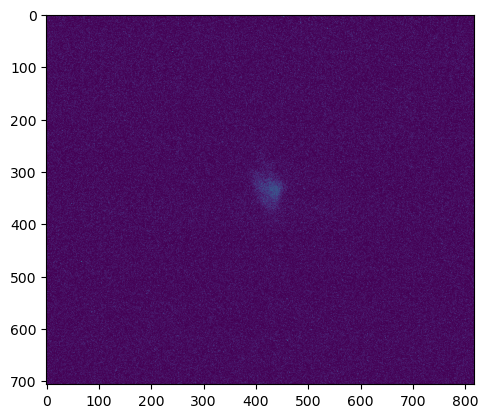

In [39]:
plt.imshow(res["images"][0])

In [40]:
res

{'images': array([[[ 0. ,  5.8,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  5.2,  0.8, ...,  1.6,  0. ,  1. ],
         [ 0. ,  0. ,  0. , ...,  3.8,  2.6,  1.4],
         ...,
         [ 0. ,  0. ,  1.8, ...,  2. ,  0. ,  5.4],
         [ 0. ,  3.4,  0. , ...,  0. ,  0.4,  0.2],
         [ 0. ,  0. ,  0.4, ...,  1.6,  0. ,  1.8]],
 
        [[ 0. ,  0. ,  2. , ...,  0. ,  0. ,  2.4],
         [ 0. ,  1.2,  0. , ...,  0. ,  0. ,  0. ],
         [ 2.2,  0. ,  5.4, ...,  3.8,  0. ,  3.4],
         ...,
         [ 1.8,  0.8,  5.8, ...,  1. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0.4,  5.4,  0. ],
         [ 0. ,  5.6,  0. , ...,  0. ,  0. ,  2.8]],
 
        [[ 0. ,  0. ,  2. , ...,  0. ,  0. ,  2.4],
         [ 0. ,  1.2,  0. , ...,  0. ,  0. ,  0. ],
         [ 2.2,  0. ,  5.4, ...,  3.8,  0. ,  3.4],
         ...,
         [ 1.8,  0.8,  5.8, ...,  1. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0.4,  5.4,  0. ],
         [ 0. ,  5.6,  0. , ...,  0. ,  0. ,  2.8]],
 
   